<a href="https://colab.research.google.com/github/ContiPaolo/EKF-SINDy/blob/Refactor/SelkovModel_OnlineLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
###########################  CLONE EKF-SINDY AND INSTALL PACKAGES  ###########################
from IPython.display import clear_output
import sys

sys.path.append('/content/EKF-SINDy')

#!rm -rf /content/EKF-SINDy
#!git clone -b Refactor https://github.com/ContiPaolo/EKF-SINDy
!pip3 install -r requirements.txt
#!pip install pysindy pyDOE filterpy
clear_output()
print("EKF-SINDy ready to go :)")

###########################                LIBRARIES                ###########################
import numpy as np
import pysindy as ps
from scipy.integrate import odeint
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pyDOE import lhs
import copy
import sympy as sp

from utils_EKFSINDy import add_noise_with_snr
from utils_EKFSINDy_online import add_noise_with_snr, extract_coefficients, model_Asindy, updateA, compute_J_library, jacobian_A_A_out, jacobian_H_Hout, numInt, plot_outcomes, plot_phase_space
seed = 1

EKF-SINDy ready to go :)


ModuleNotFoundError: No module named 'numpy'

# Selkov Model

The Selkov model equations are:

\begin{aligned}
\quad u_1' &= \rho - \sigma_1 u_1 - b_{122,1} u_1  u_2^2, \\
\quad u_2' &= \sigma_2  u_1 -k_{2}  u_2 + b_{122,2}  u_1  u_2^2.
\end{aligned}


The equilibrium point is:

$(x_0, y_0) = \left(\frac{\rho}{\sigma + \rho^2}, \rho\right)$

### Hopf Bifurcations and Stability Regions

By varying $\rho$, two Hopf bifurcations occur, defining three regions of stability:

- $\rho < 0.41$: Stable fixed point.
- $0.41 < \rho < 0.8$: Stable limit cycle.
- $\rho > 0.8$: Stable fixed point.

The bifurcation values of $\rho$ are:
- $\rho_1 = 0.41$
- $\rho_2 = 0.8$

In [2]:
# Define parameters for Sel'kov model for the offline training
system = {
    'rho'    : 0.92,
    'sigma1' : 0.10,
    'sigma2' : 0.10,
    'k2'     : 1.,
    'b122_1' : 1.,
    'b122_2' : 1.,

    't0'     : 0.00,
    'T_train': 100.,
    'dt'     : 0.10,
}

# Define the differential equations for the Sel'kov model
def f(y, t, system = system, train = True):
    u1, u2 = y
    sigma1  = system['sigma1']
    sigma2 = system['sigma2']
    k2    = system['k2']
    b112_1 = system['b122_1']
    b122_2 = system['b122_2']

    if train:
      #during training we consider a constant value of rho
      rho = system['rho']
    else:
      #during testing we vary rho (from rho_start to rho_end)
      rho_start, rho_end, T, T1, T_sweep  = system['rho_start'], system['rho_end'], system['T'], system['T1'], system['T_sweep']
      if t < T1:
          rho = rho_start
      elif t > T1+T_sweep:
          rho = rho_end
      else:
          rho = rho_start + (rho_end-rho_start)*(t-T1)/T_sweep

    #Selk'ov model:
    du1 = rho - sigma1 * u1 - b112_1 * u1 * u2**2
    du2 = sigma1 * u1 - k2 * u2 + b122_2 * u1 * u2**2

    return [du1, du2]

In [3]:
# %%
######################       GENERATE DATA       ######################

t_train = np.arange(system['t0'], system['T_train'], system['dt'])

#Generate random ICs
np.random.seed(seed=seed)
u1_0 = np.random.normal(0.2, 2, 20)
u2_0 = np.random.normal(0.2, 2, 20)

#number of instances
n_train = 16

#Generate data
Xtrain = []

for i in range(n_train):
    y0 = [u1_0[i], u2_0[i]]
    sol = odeint(f, y0, t_train, args=(system, True))
    Xtrain.append(sol)

#%%
# ######################      CREATE SINDy model       ######################
# We use SINDy to identify a model for the Sel'kov dynamics.
model = ps.SINDy(feature_names=['u1', 'u2'],
                 feature_library=ps.PolynomialLibrary(degree=3),
                 optimizer=ps.STLSQ(threshold=5e-2))
model.fit(Xtrain, t=system['dt'], multiple_trajectories=True)
model.print()

#store model coefficients
coeffs = model.coefficients()

(u1)' = 0.923 1 + -0.094 u1 + -0.076 u1 u2 + -0.929 u1 u2^2
(u2)' = 0.108 u1 + -0.934 u2 + 0.918 u1 u2^2


In [4]:
#%% Parameters for the identification of the SINDy model
system = {
    #in the identification phase we will change the parameter rho from rho_start to rho_end
    'rho_start': 0.92,
    'rho_end'  : 0.70,
    'sigma1'   : 0.10,
    'sigma2'   : 0.10,
    'k2'       : 1.,
    'b122_1'   : 1.,
    'b122_2'   : 1.,

    't0'       : 0.0,
    'T1'       : 50.,  #time instance for which the change of parameter occurs
    'T_sweep'  : 50.,  #length of the time window for which the parameter changes linearly
    'T'        : 300., #final time
    #note that we online assimilation is up to T=300, which is much longer than the training time T_train=100
    'dt'       : 0.10
}

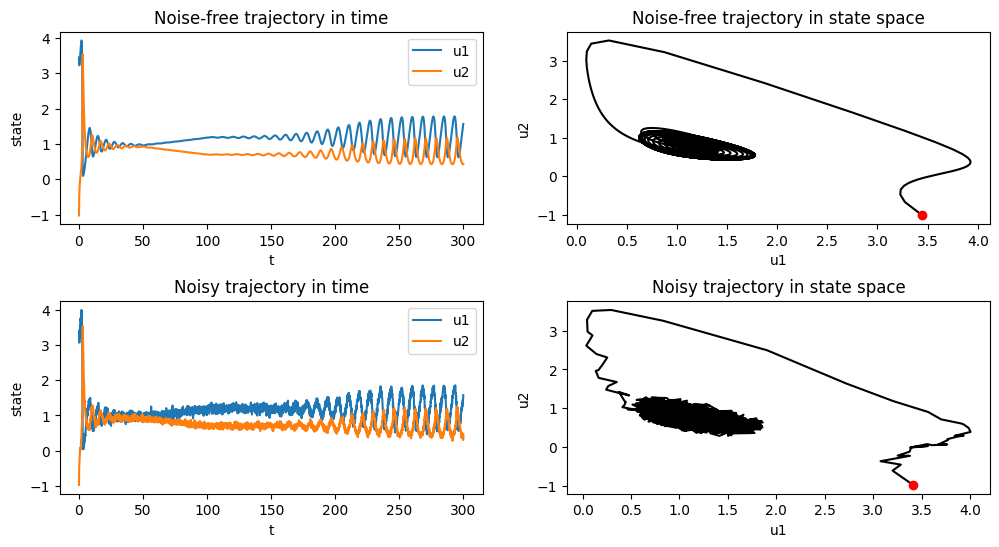

In [5]:
# %%
######################       GENERATE DATA for EKF       ######################
#Number of instances
n_test = 1

# Define the time frame
t0, T1, T, T_sweep, dt = system['t0'], system['T1'], system['T'], system['T_sweep'], system['dt']
t = np.arange(t0,T,dt)
Nt = len(t)

#Generate random ICs
np.random.seed(seed=seed)
u1_0 = np.random.normal(0.2,2,n_test)
u2_0 = np.random.normal(0.2,2,n_test)

#Generate data
y0 = np.array([u1_0[0],u2_0[0]])
X  = odeint(f,y0,t, args=(system, False))

#Plot test data
plt.figure(figsize = [12,6])
plt.subplot(2,2,1)
plt.plot(t,X[:,0],label='u1')
plt.plot(t,X[:,1],label='u2')
plt.xlabel('t')
plt.ylabel('state')
plt.title('Noise-free trajectory in time')
plt.legend()

plt.subplot(2,2,2)
plt.plot(X[:,0],X[:,1],'black')
plt.plot(u1_0[0],u2_0[0],'ro')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Noise-free trajectory in state space')

#Add noise:
X[:,0]      = add_noise_with_snr(X[:,0],25)
X[:,1]      = add_noise_with_snr(X[:,1],25)

plt.subplot(2,2,3)
plt.plot(t,X[:,0],label='u1')
plt.plot(t,X[:,1],label='u2')
plt.xlabel('t')
plt.ylabel('state')
plt.title('Noisy trajectory in time')
plt.legend()

plt.subplot(2,2,4)
plt.plot(X[:,0],X[:,1],'black')
plt.plot(X[0,0],X[0,1],'ro')
plt.xlabel('u1')
plt.ylabel('u2')
plt.title('Noisy trajectory in state space')

plt.subplots_adjust(hspace=0.4)
plt.show()

In [6]:
sindy_library_names = model.get_feature_names()

# Define symbolic variables
u1, u2 = sp.symbols('u1 u2')

# Convert feature names to symbolic expressions
terms = []
for term in sindy_library_names:
    # Replace '^' with '**' for exponentiation in SymPy and remove any spaces
    term = term.replace('^', '**').replace(' ', '*')
    try:
        terms.append(eval(term, {'u1': u1, 'u2': u2}))
    except SyntaxError as e:
        print(f"Error parsing term '{term}': {e}")

# Set up SINDy library terms and their derivatives
sindy_library = [sp.lambdify((u1, u2), expr) for expr in terms]
print("SINDy library terms:")
for expr in terms:
    print(expr)

sindy_library_du1 = [sp.lambdify((u1, u2), sp.diff(expr, u1)) for expr in terms]
print("\nDerivatives with respect to u1:")
for expr in terms:
    print(sp.diff(expr, u1))

sindy_library_du2 = [sp.lambdify((u1, u2), sp.diff(expr, u2)) for expr in terms]
print("\nDerivatives with respect to u2:")
for expr in terms:
    print(sp.diff(expr, u2))

SINDy library terms:
1
u1
u2
u1**2
u1*u2
u2**2
u1**3
u1**2*u2
u1*u2**2
u2**3

Derivatives with respect to u1:
0
1
0
2*u1
u2
0
3*u1**2
2*u1*u2
u2**2
0

Derivatives with respect to u2:
0
0
1
0
u1
2*u2
0
u1**2
2*u1*u2
3*u2**2


The model identified by SINDy offline has the form

\begin{aligned}
\quad u_1' &= \tilde{\rho} - \tilde{\sigma}_1 u_1 + {{\color{red}{\tilde{a}_{12,1} u_1u_2}}}- \tilde{b}_{122,1} u_1 u_2^2, \\
\quad u_2' &= \tilde{\sigma}_2 u_1  -\tilde{k}_{2,2} u_2 + \tilde{b}_{122,2} u_1  u_2^2,
\end{aligned}

where the term ${\tilde{a}_{12,1} u_1u_2}$ is (erroneously) indicated as relevant (non zero), while it is absent in the original model, i.e. $a_{12,1}=0$.

All the coefficients are stored in the matrix $\Xi$ which is given by `coeffs`.
We make use of the function `extract_coefficients` to construct $\tilde{\Xi}$ and $\Xi_0$, namely the coefficients that we want to montior and the ones which we keep frozen.

In [7]:
#%% Initialize the SINDy-EKF setup

n_eqs = N_x = 2  # Number of equations (states)
N_obs  = 2       # Number of observed states (we observe all the states)
N_xu   = 2       # Overall number of states and forcing terms (we have no forcing)

# Extract nonzero coefficients from the SINDy model identified offline
non_zero_coeff_indices = np.nonzero(coeffs)
#it returns a list where the first element indicates the equation of the nonzero coefficients
#and the second element indicates the number of the nonzero term in the corresponding equation

eqOfInterest = non_zero_coeff_indices[0]
funct_names =  [terms[i] for i in non_zero_coeff_indices[1]]


In this case we monitor all the nonzero coefficients identified by SINDy, namely
$$[\tilde{\rho}, \tilde{\sigma_1}, \tilde{a}_{12,1}, \tilde{b}_{122,1}, \tilde{\sigma_2}, \tilde{k}_{2,2}, \tilde{b}_{122,2}],$$
and collect them in $\tilde{\Xi}$.

All the other coefficients (the ones set to zero by the offline SINDy) are kept frozen to zero, not monitored and collected in $\Xi_0$.

In [11]:
# We monitor all the nonzero coefficients identified by SINDy
keepEntries = np.arange(len(non_zero_coeff_indices[0]))
#Coefficient names and corresponding ground truth value
coeff_names     = ['rho','sigma_1','a12_1', 'b122_1','sigma_2','k2_2', 'b122_2']
true_coeff      = [system['rho_start'],-system['sigma1'],0.0,-system['b122_1'],system['sigma2'],-system['k2'],system['b122_2']]

# We don't monitor the zero coefficients identified by SINDy
eqOfInterestOut = []
takeOutEntries = []

N_param = len(keepEntries)

# Construct the matrix of coefficients to be monitored $\tilde{\Xi}$
(
    B_map,
    unique_terms,
    sindy_terms,
    term_names,
    A,
    sindy_derivatives_u1,
    sindy_derivatives_u2,
) = extract_coefficients(coeffs, keepEntries, eqOfInterest, sindy_library, sindy_library_names, sindy_library_du1, sindy_library_du2, n_eqs)

# Construct the matrix of coefficients to keep frozen $\Xi_0$
(
    B_map_out,
    unique_terms_out,
    sindy_terms_out,
    term_names_out,
    A_out,
    sindy_derivatives_u1_out,
    sindy_derivatives_u2_out,
) = extract_coefficients(coeffs, takeOutEntries, eqOfInterestOut, sindy_library, sindy_library_names, sindy_library_du1, sindy_library_du2, n_eqs)

# Observations and parameters setup
h_coeffs     = np.zeros(shape=(N_obs,A.shape[1]))
h_coeffs[0,1] = 1.0  #[0,1,4,8] --> u1
h_coeffs[1,1] = 1.0  #[1,2,8]   --> u2
h_coeffs_out = np.zeros(shape=(N_obs,len(unique_terms)))

In [13]:
# %% Filter tuning

Nt_analysis = int(Nt)

# Define variation for all terms ***********************************************************
p0_u = 1e-8
p0_param = [5e-4, 1e-3, 5e-4, 1e-3, 1e-4, 5e-4, 1e-3]  # rho, sigma_1, a12_1, b122_1, sigma_2, k2_2, b122_2

# Process noise
q_u_1, q_u_2 = 8e-7, 8e-7
q_param = [5e-6, 1e-9, 1e-10, 1e-10, 1e-11, 1e-9, 1e-12]  # rho, sigma_1, a12_1, b122_1, sigma_2, k2_2, b122_2

# Measurement noise
r_u_1, r_u_2 = 5e-4, 5e-4
# ******************************************************************************************

# Initializations
xhat_hist, obs_hist, P_hist, xhat_piu_sigma_hist, xhat_meno_sigma_hist = [], [], [], [], []

# Initialize covariance matrix
P = np.identity(N_x + N_param)
P[:N_xu, :N_xu] = P[:N_xu, :N_xu] * p0_u
for param_idx in np.arange(N_param):
    P[N_xu + param_idx, N_xu + param_idx] = P[N_xu + param_idx, N_xu + param_idx] * p0_param[param_idx]

# Initialize process noise matrix
Q = np.identity(N_x + N_param)
Q[0, 0] = Q[0, 0] * q_u_1
Q[1, 1] = Q[1, 1] * q_u_2
for param_idx in np.arange(N_param):
    Q[N_xu + param_idx, N_xu + param_idx] = Q[N_xu + param_idx, N_xu + param_idx] * q_param[param_idx]

# Initialize measurement noise matrix
R = np.identity(N_obs)
R[0, 0] = R[0, 0] * r_u_1
R[1, 1] = R[1, 1] * r_u_2

# Define an identity matrix of the same size as the number of state variables
I = np.identity(N_x + N_param)

# Copy the transition and observation coefficient matrices for updates
Aupd = copy.copy(A)
h_coeffs_upd = copy.copy(h_coeffs)


In [ ]:
# %% define ekf_sindy function
def ekf_sindy(X_data_obs, Aupd, A_out, h_coeffs_upd, system, P, Q, I, Nt, n_eqs):
    # Initialization
    xhat_taxis, obs_taxis, P_taxis = np.zeros(shape=(N_x + N_param, Nt)), np.zeros(shape=(N_obs, Nt)), np.zeros(shape=(N_x + N_param, N_x + N_param, Nt))
    xhat_taxis_piu_sigma, xhat_taxis_meno_sigma = np.zeros(shape=(N_x + N_param, Nt)), np.zeros(shape=(N_x + N_param, Nt))

    xhat = np.zeros(shape=(N_x + N_param))

    xhat[0:-N_param] = X_data_obs[0]
    i1 = 0
    for i0 in np.arange(N_param):
        xhat[N_x + i0] = Aupd[eqOfInterest[i0], i0 - i1]
        if i0 < (N_param - 1):
            if eqOfInterest[i0 + 1] > eqOfInterest[i0]:
                i1 += i0 + 1

    xhat_taxis[:, 0], obs_taxis[:, 0], P_taxis[:, :, 0] = xhat, xhat[0:-N_param], P

    # Kalman filter run
    t_plus_1 = t0

    for i0 in range(1, Nt):
        t_ = t_plus_1
        t_plus_1 = t_ + dt

        out = X_data_obs[i0]
        param = xhat[-N_param:]

        # Prediction phase
        xhat_pred, P_pred = numInt(xhat[0:-N_param], param, dt, t_, sindy_terms, sindy_terms_out, Aupd, A_out, P, Q, sindy_derivatives_u1, sindy_derivatives_u2, sindy_derivatives_u1_out, sindy_derivatives_u2_out, n_eqs, method='RK4')
        xhat_pred = np.append(xhat_pred, param)
        # end Predictor phase

        # Corrector phase
        H = jacobian_H_Hout(h_coeffs_upd, h_coeffs_out, xhat_pred[:-N_param], param, t_plus_1, sindy_derivatives_u1, sindy_derivatives_u2, sindy_derivatives_u1_out, sindy_derivatives_u2_out)
        # Compute Kalman gain
        G = np.matmul(np.matmul(P_pred, H.transpose()), np.linalg.inv(np.matmul(np.matmul(H, P_pred), H.transpose()) + R))
        obs = model_Asindy(h_coeffs_upd, xhat_pred[:-N_param], t_plus_1, sindy_terms) + model_Asindy(h_coeffs_out, xhat_pred[:-N_param], t_plus_1, sindy_terms_out)
        if N_obs == 1:
            xhat = xhat_pred + np.matmul(G, np.expand_dims(out - obs, axis=0))
        else:
            xhat = xhat_pred + np.matmul(G, (out - obs))

        # Update covariance matrix
        P = np.matmul(np.matmul(I - np.matmul(G, H), P_pred), (I - np.matmul(G, H)).transpose()) + np.matmul(np.matmul(G, R), G.transpose())
        # end Corrector phase

        xhat_taxis[:, i0], obs_taxis[:, i0], P_taxis[:, :, i0] = xhat, obs, P

        # Update transition model
        Aupd = updateA(Aupd, xhat[-N_param:])

    for i5 in range(N_x + N_param):
        # Assumption - diagonal covariance matrix
        xhat_taxis_piu_sigma[i5, :] = xhat_taxis[i5, :] + 1.96 * np.sqrt(P_taxis[i5, i5, :])
        xhat_taxis_meno_sigma[i5, :] = xhat_taxis[i5, :] - 1.96 * np.sqrt(P_taxis[i5, i5, :])

    return Aupd, xhat, P, Q, xhat_taxis, obs_taxis, P_taxis, xhat_taxis_piu_sigma, xhat_taxis_meno_sigma


In [15]:
Aupd,xhat,P,Q,xhat_taxis,obs_taxis,P_taxis,xhat_taxis_piu_sigma,xhat_taxis_meno_sigma = ekf_sindy(X,Aupd,A_out,h_coeffs_upd,system,P,Q,I,Nt_analysis)

TypeError: jacobian_A_A_out() missing 1 required positional argument: 'n_eqs'

In [ ]:
ntsp = 0
ntst = Nt_analysis

# %% Plot outcomes
t_axis, rho_step = plot_outcomes(t, X, xhat_taxis, xhat_taxis_piu_sigma, xhat_taxis_meno_sigma, obs_taxis, N_x, N_param, true_coeff, coeff_names)

# %% Plot phase space
ntsp = 0
ntst = int(Nt_analysis)
plot_equil = 0
plot_bounds = 0
plot_phase_space(t, X, xhat_taxis, xhat_taxis_piu_sigma, xhat_taxis_meno_sigma, obs_taxis, N_x, plot_equil, plot_bounds, true_coeff)

### **References**

[1] Rosafalco, Conti, Manzoni, Mariani, Frangi [Online learning in bifurcating dynamic systems via SINDy and Kalman filtering](https://arxiv.org/abs/2309.00325), arXiv (2024).

[2] Rosafalco, Conti, Manzoni, Mariani, Frangi. [EKF-SINDy: Empowering the extended Kalman filter with sparse identification of nonlinear dynamics](https://www.sciencedirect.com/science/article/abs/pii/S0045782522007678?via%3Dihub), Computer methods in applied mechanics and engineering (2024).

⭐ Leave a star to the github repos if you enojyed :)

### **Extra**
To evaluate the robustness of the online procedure, we have adopted a *poor* SINDy model for the Selkov dynamics by setting the threshold parameter $L=0.2$ instead of $L=0.05$.

The model obtained with $L=0.2$ deviates significantly more from the reference compared to the one determined with $L=0.05$. Notably, this model entirely omits the $x_1$ term, which is weighted by the coefficients $\sigma_1$ and $\sigma_2$ in $f_1$ and $f_2$, respectively.

As it is shown in the following, the procedure demonstrates remarkable robustness, as the identification outcomes are once again satisfactory, successfully recovering the correct values of the missing terms $\sigma_1$ and $\sigma_2$. As unique warning, we observe that it has been necessary to initially set the values of $\sigma_1$ and $\sigma_2$ to $10^{-9}$, a small value but different from $0$, to ensure sensitivity to these parameters in the Jacobian matrix.

In [ ]:
# ######################      Offline SINDy     ######################
threshold = 0.2
model = ps.SINDy(feature_names=['u1', 'u2'],
                 feature_library=ps.PolynomialLibrary(degree=3),
                 optimizer=ps.STLSQ(threshold=threshold))
model.fit(Xtrain, t=system['dt'], multiple_trajectories=True)
model.print()

#store model coefficients
coeffs = model.coefficients()
#we assign a non-zero values to the coefficients we to the linear terms 'u1' to keep track of them
coeffs[0,1] = 1e-9
coeffs[1,1] = 1e-9

non_zero_coeff_indices = np.nonzero(coeffs)
eqOfInterest = non_zero_coeff_indices[0]
keepEntries = np.arange(len(non_zero_coeff_indices[0]))

N_param = len(keepEntries)

coeff_names     = ['rho','sigma_1', 'b122_1','sigma_2','k2_2', 'b122_2']
funct_names     = [  '1',     'u1','u1*u2^2',     'u1',  'u2','u1*u2^2']

true_coeff      = [system['rho_start'],-1*system['sigma1'],-1.0,system['sigma2'],-system['b122_1'],system['b122_2']]
eqOfInterestOut = []
takeOutEntries = []

# Construct the matrix of coefficients to be monitored $\tilde{\Xi}$
B_map, unique_terms, sindy_terms, term_names, A, sindy_derivatives_u1, sindy_derivatives_u2 = extract_coefficients(coeffs, keepEntries, eqOfInterest)
# Construct the matrix of coefficients to keep frozen $\Xi_0$
B_map_out, unique_terms_out, sindy_terms_out, term_names_out, A_out, sindy_derivatives_u1_out, sindy_derivatives_u2_out = extract_coefficients(coeffs, takeOutEntries, eqOfInterestOut)


# %% Filter tuning

# Define variation for all terms ***********************************************************
p0_param = [5e-4, 1e-3, 1e-3, 1e-4, 5e-4, 1e-3]  # rho, sigma_1, b122_1, sigma_2, k2_2, b122_2

# Process noise
q_param = [5e-6, 1e-9, 1e-10, 1e-11, 1e-9, 1e-12] # rho, sigma_1, b122_1, sigma_2, k2_2, b122_2


# ******************************************************************************************

# Initializations
xhat_hist, obs_hist, P_hist, xhat_piu_sigma_hist, xhat_meno_sigma_hist = [], [], [], [], []

# Initialize covariance matrix
P = np.identity(N_x + N_param)
P[:N_xu, :N_xu] = P[:N_xu, :N_xu] * p0_u
for param_idx in np.arange(N_param):
    P[N_xu + param_idx, N_xu + param_idx] = P[N_xu + param_idx, N_xu + param_idx] * p0_param[param_idx]

# Initialize process noise matrix
Q = np.identity(N_x + N_param)
Q[0, 0] = Q[0, 0] * q_u_1
Q[1, 1] = Q[1, 1] * q_u_2
for param_idx in np.arange(N_param):
    Q[N_xu + param_idx, N_xu + param_idx] = Q[N_xu + param_idx, N_xu + param_idx] * q_param[param_idx]

# Define an identity matrix of the same size as the number of state variables
I = np.identity(N_x + N_param)

# Copy the transition and observation coefficient matrices for updates
Aupd = copy.copy(A)
h_coeffs_upd = copy.copy(h_coeffs)

# ######################      Online EKF-SINDy     ######################
Aupd,xhat,P,Q,xhat_taxis,obs_taxis,P_taxis,xhat_taxis_piu_sigma,xhat_taxis_meno_sigma = ekf_sindy(X,Aupd,A_out,h_coeffs_upd,system,P,Q,I,Nt_analysis)

# %% Plot outcomes
t_axis, rho_step = plot_outcomes(t, X, xhat_taxis, xhat_taxis_piu_sigma, xhat_taxis_meno_sigma, obs_taxis, N_x, N_param, true_coeff, coeff_names)

# %% Plot phase space
plot_phase_space(t, X, xhat_taxis, xhat_taxis_piu_sigma, xhat_taxis_meno_sigma, obs_taxis, N_x, plot_equil, plot_bounds, true_coeff)